In [ ]:
import os
import torch
import nibabel as nib
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTokenizer, CLIPTextModel, CLIPProcessor
from torch import nn
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import re
import json
from tqdm.auto import tqdm
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

drive.mount('/mnt/drive')

Mounted at /mnt/drive


In [ ]:
# Set up general file path for the data
file_path = "/mnt/drive/MyDrive/fMRI_data/"
p = Path(file_path)

# Annotation dataset

In [ ]:
# Prepare the annotation lists and strings

# AlexNet
file_path_AN = "/mnt/drive/MyDrive/Image_Labels/imagenet_final_labels.txt"
records = []

with open(file_path_AN, "r") as f:
    for line in f:
        # Split the line by whitespace
        parts = line.strip().split()

        # The first part is the image_ID
        image_id = parts[0]

        # The remaining parts form the image description
        description = " ".join(parts[1:])

        records.append((image_id, description))

# Create a DataFrame with the two columns
df_AN = pd.DataFrame(records, columns=["image_ID", "image description"])


# COCO
file_path_coco = "/mnt/drive/MyDrive/Image_Labels/coco_annotations/captions_train2014.json"

with open(file_path_coco) as f:
    d = json.load(f)

annot_list_COCO = d["annotations"]

In [ ]:
# Create the full list of annotations and save this pre-processed data file

file_list_imgs = sorted([str(x) for x in p.glob("*_imgnames.txt") if x.is_file()])
annot_list_total = []

for participant_file in file_list_imgs:

    DF_img_names = pd.read_csv(participant_file, header=None, names=["img_name"])

    # List of all annotations for the specific participant
    annot_list = []

    for img_name in DF_img_names["img_name"]:

        # Check if we're dealing with AlexNet
        if img_name.endswith('JPEG'):

            # Call some function to get the AlexNet annotation
            raw_string = img_name.replace('.JPEG', "").split("_")[0]
            annotation = df_AN.loc[df["image_ID"] == raw_string, "image description"].values[0]
            annot_list.append(annotation)

        # Or COCO
        elif img_name.startswith('COCO'):

            raw_string = img_name.replace("COCO_train2014_000000", "").replace(".jpg", "")

            annotation = ""
            for entry in annot_list_COCO:
                if entry["image_id"] == int(raw_string):
                    annotation = entry["caption"]
                    break

            annot_list.append(annotation)

        # Or SUN
        else:
            raw_string = img_name.replace(".jpg", "")
            annotation = re.sub(r"\d+", "", stripped_string)
            annot_list.append(annotation)

    annot_list_total.append(annot_list)

# Make sure we save the file
with open("/mnt/drive/MyDrive/annot_list_total.pkl", "wb") as f:
    pickle.dump(annot_list_total, f)

# fMRI dataset

In [ ]:
# Loading the nifty files, concatenating, removing outliers. Be careful, this
# takes a lot of time and eats a tonne of RAM

# Loop through participants
for participant in range(1, 5):

    # Prep the list of available files
    pathlib_gen = p.glob(f"CSI{participant}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses*")
    file_list = sorted([str(x) for x in pathlib_gen if x.is_file()])

    # Since I reliably crash the Colab notebook otherwise, only use a smaller subset of data
    file_list = file_list[:6]

    # Concatenate all the fMRI data along the time dimension
    concat_nifty = np.concatenate([nib.load(file).get_fdata() for file in file_list], axis=3)

    # Remove outliers
    threshold = np.nanquantile(np.abs(concat_nifty), 0.95)
    concat_nifty[np.abs(concat_nifty) > threshold] = np.nan

    np.save(f"{file_path}concat_fMRI_data_cleaned_part{participant}.npy", concat_nifty, allow_pickle=True)

# Examples and fMRI data familiarisation

Naturally, we'd be very bad scientists if we didn't visualise the data. We can run a simple function to view a single slice through the brain. The mask is passable, but note the very important presence of outliers on the edges of the head. These are most likely motion artefacts (or possibly scanner field distortions due to air cavities) and not real data points and thus we have to make sure they're removed.

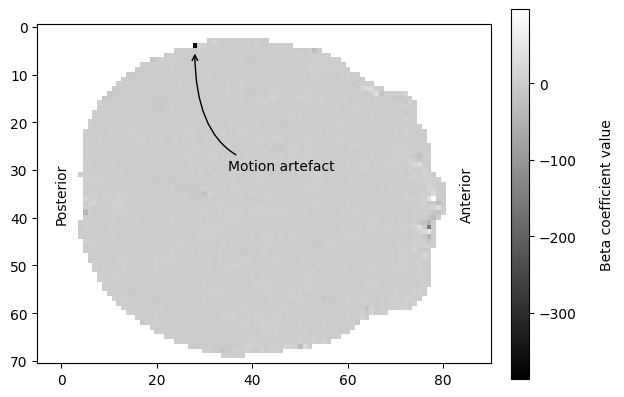

In [ ]:
example_file = '/mnt/drive/MyDrive/fMRI_data/CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'
example_data = nib.load(example_file).get_fdata()
im = plt.imshow(example_data[:, :, 40, 50], cmap='gray')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Beta coefficient value', labelpad=17)
plt.text(0, 35, "Posterior", ha="center", va="center", rotation=90, fontsize=10)
plt.text(85, 35, "Anterior", ha="center", va="center", rotation=90, fontsize=10)
plt.xlim(-5, 90)

plt.annotate('Motion artefact', xy=(28, 5), xytext=(35, 30),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));

plt.savefig("motion_artefact.pdf", bbox_inches="tight")
plt.show()

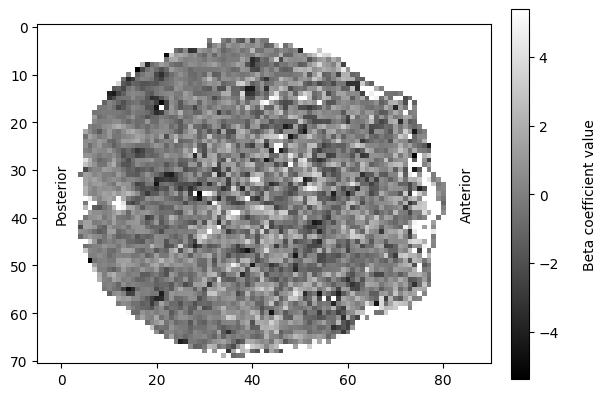

In [ ]:
# Repeat the example but for illustrative purposes get rid of the outliers
example_flat = example_data.flatten()
example_threshold = np.nanquantile(abs(example_flat), 0.95)
example_flat[abs(example_flat) > example_threshold] = np.NaN
example_data_outlier_rm = example_flat.reshape(example_data.shape)

im = plt.imshow(example_data_outlier_rm[:, :, 40, 50], cmap='gray')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Beta coefficient value', labelpad=17)
plt.text(0, 35, "Posterior", ha="center", va="center", rotation=90, fontsize=10)
plt.text(85, 35, "Anterior", ha="center", va="center", rotation=90, fontsize=10)
plt.xlim(-5, 90)
plt.show()

While the above looks far more noisy, we've actually done ourserlves a huge service because now differences between individual voxels are far more prominent, especially in the middle of the brain, whereas previous they were extremely hard to distinguish.

Another way of ensuring our data is of good quality is plotting the relevant histogram, see below (normal distribution with not too crazy tails is what we are after)

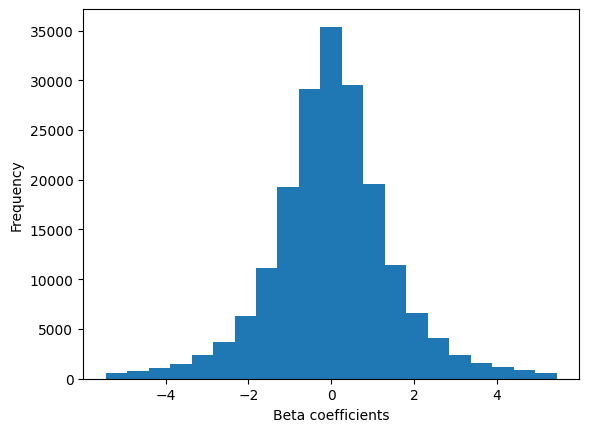

In [ ]:
plt.hist(example_data_outlier_rm[:, :, :, 50].flatten(), bins=21)
plt.xlabel("Beta coefficients")
plt.ylabel("Frequency")
plt.show()

# Data setup

In [ ]:
# Load the annotations
annot_data_path = "/mnt/drive/MyDrive/annot_list_total.pkl"

with open(annot_data_path, 'rb') as f:
  annotations = pickle.load(f)

The fMRI data is extremely high dimensional. There are several ways to go abour this problem (excluding buying up very powerful servers with immense computing capabilities). The most straightforward one, implemented here, is linear dimensionality reduction.

Each VOXEL (3D portion of space) is a separate DIMENSION with a VALUE (the beta coefficinets). We construct new dimensions (principal component) that are linear combinations of the old dimensions (voxels) and only keep the 200 that account for the most variance in the data. Definitely not the ideal approach (tSNE or 3D convolution would likely have been better).

In [ ]:
def fmri_dim_red(x: np.ndarray, n_components = 200) -> np.ndarray:

  """
  This function pre-processes the data in a way that we need before feeding it to the encoder.
  The primary functionality we're after is dimensionality reduction since this is a huge problem in fMRI data.
  """

  # Keep track of the time points for later matching of annots
  global T_vals # Not the most aesthetic way of doing it, but it works fine
  T_vals.append(x.shape[-1])

  # Reshape
  x_reshaped = x.reshape(-1, x.shape[-1])

  # Replace NaN values with 0s
  np.nan_to_num(x_reshaped, copy=False)

  # Apply PCA
  scaler = StandardScaler(with_mean=True, with_std=True)
  pca = PCA(n_components=n_components, random_state=42)
  x_zscored = scaler.fit_transform(x_reshaped.T)  # shape still (dims, time_points)

  # Scikit-learn wants shape of (samples, features) for pca.fit_transform()
  # so we gotta transpose x_zscored -> shape: (time_points, dims)
  return pca.fit_transform(x_zscored).T # the shape is (n_components, time_points)


In [ ]:
# Stack all the fMRI data together (NB: This takes a while and consumes quite a lot of RAM)
pathlib_gen_fmri_done = p.glob(f"concat_fMRI_data_cleaned_part*")
fmri_file_list = sorted([str(x) for x in pathlib_gen_fmri_done if x.is_file()])
T_vals = []
X_total = np.hstack([fmri_dim_red(np.load(fmri_file, allow_pickle=True)) for fmri_file in fmri_file_list])

In [ ]:
# Put together the annotations
y_total = []
for i, T_val in enumerate(T_vals):
  y_total.extend(annotations[i][:T_val])

# Put a check in place to make sure we've done the data prep correctly
assert len(y_total) == X_total.shape[-1], "Mismatch between fMRI and text data."

In [ ]:
# Perform the train/val/test split. We'll use a single-fold validation,
# lest I burn the server to the ground, though K-fold CV should be mentioned
# in the final report

# Split Train/Val/Test => 60 %, 20 %, 20 %
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_total.T, y_total, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

# Convert back to shape (n_components, N)
X_train, X_val, X_test = X_train.T, X_val.T, X_test.T

# Model setup and training

In [ ]:
# Constants
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 300

# Learning rate scheduler would be better but  I haven't got the time to
# implement it
LEARNING_RATE = 5e-5

# Custom Dataset for Text and fMRI data
class TextFMRI_Dataset(Dataset):
    def __init__(self, fmri_data, text_descriptions, tokenizer, max_length=77):
        self.fmri_data = fmri_data
        self.text_descriptions = text_descriptions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text_descriptions)

    def __getitem__(self, idx):
        fmri_sample = torch.tensor(self.fmri_data[:, idx], dtype=torch.float32)
        text = self.text_descriptions[idx]
        encoded_text = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return fmri_sample, encoded_text['input_ids'].squeeze(0), encoded_text['attention_mask'].squeeze(0)

# fMRI Encoder Model
# An attention head of some sort here would probably go quite a long way
class FMRIEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FMRIEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )


    # Remember to override the forward method
    def forward(self, x):
        return self.encoder(x)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    # Put model in train mode for changing weights
    model.train()

    train_loss = 0

    # Loop through data loader data batches
    for batch, (fmri, input_ids, attention_mask) in enumerate(dataloader):

        # Send data to the GPU
        fmri, input_ids, attention_mask = fmri.to(DEVICE), input_ids.to(DEVICE), attention_mask.to(DEVICE)

        # Forward pass
        text_features = text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        fmri_features = model(fmri)

        # Compute cosine similarity
        text_features = text_features / (text_features.norm(dim=1, keepdim=True) + 0.0000001)
        fmri_features = fmri_features / (fmri_features.norm(dim=1, keepdim=True) + 0.0000001)

        # Nota bene: what I am doing here is not quite contrastive learning because
        # I am not considering negative pairs, only positive pairs, hence why the similarity
        # target is only made up of ones. Therefore, while this project is closely
        # aligned with self-supervised learning, I don't think it fully qualifies
        similarity_target = torch.ones(fmri_features.size(0)).to(DEVICE)

        # Calculate loss
        loss = loss_fn(fmri_features, text_features, similarity_target)
        train_loss += loss.item()

        # Optimiser zero grad, go back, optimiser step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate loss PER SAMPLE, to ensure the loss is batch-size invariant
    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    # Put model in eval mode
    model.eval()

    val_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches (16 samples by default)
        for batch, (fmri, input_ids, attention_mask) in enumerate(dataloader):
            fmri, input_ids, attention_mask = fmri.to(DEVICE), input_ids.to(DEVICE), attention_mask.to(DEVICE)

            # Forward pass
            text_features = text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
            fmri_features = model(fmri)

            # Compute cosine similarity
            text_features = text_features / (text_features.norm(dim=1, keepdim=True) + 0.0000001)
            fmri_features = fmri_features / (fmri_features.norm(dim=1, keepdim=True) + 0.0000001)
            similarity_target = torch.ones(fmri_features.size(0)).to(DEVICE)

            # Calculate validation loss on unseen data
            loss = loss_fn(fmri_features, text_features, similarity_target)
            val_loss += loss.item()

    # Calculate loss PER SAMPLE, to ensure the loss is batch size invariant
    val_loss = val_loss / len(dataloader)
    return val_loss


# Set up the training function, I used boilerplate code for this and modified it a lot
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):

    results = {"train_loss": [],
        "val_loss": []
    }

    # Iterate over training and validation steps
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"val_loss: {val_loss:.4f} | "
        )

        # Update the results
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)

    return results

In [ ]:
# Initialise tokeniser, text encoder, and loss function
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)
text_model = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE)
loss_fn = torch.nn.CosineEmbeddingLoss(margin=0.0)

# Create all datasets
train_dataset = TextFMRI_Dataset(X_train, y_train, tokenizer)
val_dataset   = TextFMRI_Dataset(X_val,   y_val,   tokenizer)
test_dataset  = TextFMRI_Dataset(X_test,  y_test,  tokenizer)

# Wrap the datasets with respective data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Instantiate the fMRI encoder model and the related optimiser
fmri_encoder = FMRIEncoder(input_dim=X_train.shape[0], output_dim=512).to(DEVICE)
optimizer = AdamW(fmri_encoder.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# train the model
model_results = train(model = fmri_encoder, train_dataloader = train_loader,
          test_dataloader = test_loader, optimizer = optimizer,
          loss_fn = loss_fn, epochs = EPOCHS)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9285 | val_loss: 0.9221 | 
Epoch: 2 | train_loss: 0.9154 | val_loss: 0.9149 | 
Epoch: 3 | train_loss: 0.9022 | val_loss: 0.8905 | 
Epoch: 4 | train_loss: 0.8890 | val_loss: 0.8797 | 
Epoch: 5 | train_loss: 0.8743 | val_loss: 0.8798 | 
Epoch: 6 | train_loss: 0.8580 | val_loss: 0.8542 | 
Epoch: 7 | train_loss: 0.8413 | val_loss: 0.8203 | 
Epoch: 8 | train_loss: 0.8240 | val_loss: 0.8145 | 
Epoch: 9 | train_loss: 0.8068 | val_loss: 0.7869 | 
Epoch: 10 | train_loss: 0.7910 | val_loss: 0.7801 | 
Epoch: 11 | train_loss: 0.7777 | val_loss: 0.7791 | 
Epoch: 12 | train_loss: 0.7650 | val_loss: 0.7541 | 
Epoch: 13 | train_loss: 0.7547 | val_loss: 0.7631 | 
Epoch: 14 | train_loss: 0.7463 | val_loss: 0.7612 | 
Epoch: 15 | train_loss: 0.7387 | val_loss: 0.7513 | 
Epoch: 16 | train_loss: 0.7308 | val_loss: 0.7427 | 
Epoch: 17 | train_loss: 0.7245 | val_loss: 0.7302 | 
Epoch: 18 | train_loss: 0.7179 | val_loss: 0.7330 | 
Epoch: 19 | train_loss: 0.7122 | val_loss: 0.7189 | 
Ep

In [ ]:
# Save model params and the loss curves

torch.save(fmri_encoder.state_dict(), "/mnt/drive/MyDrive/fMRI_data/fmri_encoder.pth")

with open("/mnt/drive/MyDrive/fMRI_data/model_results.json", "w") as f:
    json.dump(model_results, f, indent=4)

# Results

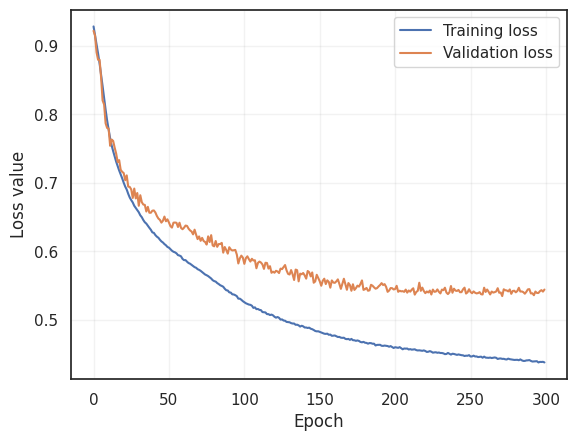

In [ ]:
sns.set_style("white")
plt.plot(model_results["train_loss"], label="Training loss")
plt.plot(model_results["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.grid(color='gray', alpha=0.1)
plt.legend()
plt.savefig("loss_figure.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Evaluate the final accuracy of the model on the completely unseen dataset.
# Compare this to randomly shuffled data

def evaluate_accuracy(fmri_encoder, text_model, dataloader, device=DEVICE):
    fmri_encoder.eval()
    text_model.eval()
    correct = 0
    correct_shuffled = 0
    total = 0

    with torch.inference_mode():
        for fmri, input_ids, attention_mask in dataloader:
            fmri = fmri.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Forward pass through text and fmri models
            text_features = text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
            fmri_features = fmri_encoder(fmri)

            # Normalise embeddings to unit length, make sure it's computationally stable
            text_features = text_features / (text_features.norm(dim=1, keepdim=True) + 0.000001)
            fmri_features = fmri_features / (fmri_features.norm(dim=1, keepdim=True) + 0.000001)

            # Compute similarity matrix, the shape should be (batch_size, batch_size)
            # Rows are fMRI embeddings whereas columns are text embeddings
            similarity = torch.mm(fmri_features, text_features.t())

            # For each fMRI sample i, find the text sample j that
            # yields the highest similarity (product). If j == i, it's a  match
            preds = similarity.argmax(dim=1) # Per column (each row returns one max value)
            labels = torch.arange(similarity.size(0), device=device)
            correct += (preds == labels).sum().item()
            total   += similarity.size(0)

            # Randomly shuffle the fMRI features and repeat the process
            shuffled_indices = torch.randperm(fmri_features.size(0))
            fmri_features_shuffled = fmri_features[shuffled_indices]
            similarity_shuffled = torch.mm(fmri_features_shuffled, text_features.t())
            preds_shuffled = similarity_shuffled.argmax(dim=1)
            correct_shuffled += (preds_shuffled == labels).sum().item()

    accuracy_shuffled = correct_shuffled / total
    accuracy = correct / total
    return accuracy, accuracy_shuffled

test_acc, shuffled_acc = evaluate_accuracy(fmri_encoder, text_model, test_loader, device=DEVICE)
print(f"Test accuracy for a trained model was {100*test_acc:.2f} % and the accurancy on randomly shuffled data was {100*shuffled_acc:.2f} %.")

Test accuracy for a trained model was 7.93 % and the accurancy on randomly shuffled data was 5.76 %.
